In [1]:
import nltk
from nltk.corpus import brown
from nltk.tbl.template import Template
from nltk.tag import untag, DefaultTagger, BrillTagger, brill, brill_trainer,BrillTaggerTrainer
import numpy as np
import pandas as pd
import pycrfsuite
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# Loading the dataset

In [3]:
dataset = brown.tagged_sents(tagset='universal')

# Split the dataset into training and testing sets

train_size = int(len(dataset) * 0.8)
train_data = dataset[:train_size]
test_data = dataset[train_size:]

# Descriptive statistics

In [4]:
tagged_words = [item for sublist in dataset for item in sublist]
tag_labels = [tag for (word, tag) in tagged_words]
tag_label_counts = nltk.FreqDist(tag_labels)

pos = ['Determiner','Noun','Adjective', 'Verb','Adposition','Punctuation','Adverb','Conjunction','Particle','Pronoun','Numeral','Other' ]
abbr = list(tag_label_counts.keys())
count = list(tag_label_counts.values())

df = pd.DataFrame({'PoS name':pos, 'abbr.':abbr, 'count':count}).sort_values('count', ascending=False)
print(tabulate(df, headers=df.columns, tablefmt="simple"))

    PoS name     abbr.      count
--  -----------  -------  -------
 1  Noun         NOUN      275558
 3  Verb         VERB      182750
 5  Punctuation  .         147565
 4  Adposition   ADP       144766
 0  Determiner   DET       137019
 2  Adjective    ADJ        83721
 6  Adverb       ADV        56239
 9  Pronoun      PRON       49334
 7  Conjunction  CONJ       38151
 8  Particle     PRT        29829
10  Numeral      NUM        14874
11  Other        X           1386


<AxesSubplot:xlabel='PoS name', ylabel='count'>

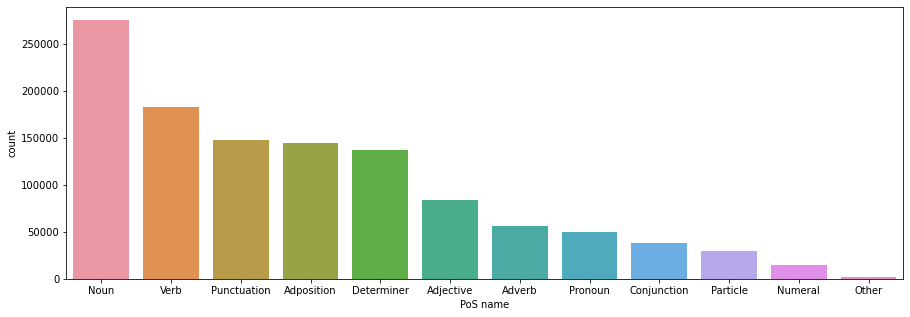

In [5]:
plt.figure(figsize=(15,5))
sns.barplot(x= df['PoS name'], y =df['count'], width=0.8 )

# Training the models

In [6]:
#HMM tagger
hmm_tagger = nltk.HiddenMarkovModelTagger.train(train_data)

# Naive bayes tagger
nb_tagger = nltk.tag.sequential.ClassifierBasedPOSTagger(train = train_data)

#Ngram tagger
ngram_tagger =  nltk.tag.sequential.NgramTagger(n = 2, train = train_data, backoff = nb_tagger )

#CRF tagger
crf_tagger = nltk.tag.crf.CRFTagger()
crf_tagger.train(train_data, 'model.crf.tagger')

# Fitting

In [7]:
def predict(data, model):
    sents_to_predict =  [[word for (word,tag) in sent] for sent in data]
    predicted_tags = [model.tag(sent) for sent in sents_to_predict]
    return [tag for sent in predicted_tags for (word,tag) in sent]



predictions = {}
datasets = {"train" : train_data, "test" : test_data}
models = {'HMM' : hmm_tagger,'Naive Bayes': nb_tagger,'NGram' : ngram_tagger,'CRf' : crf_tagger}

for key, dataset in datasets.items():
    predictions[key] = {}
    for name, model in models.items():
        predictions[key][name] = predict(dataset, model)



In [8]:
test_tags = [tag for sent in test_data for (word, tag) in sent]
train_tags = [tag for sent in train_data for (word, tag) in sent]

tags = {"train" : train_tags, "test" : test_tags}
accuracy_scores = {}
f1_scores = {}

for key in predictions:
    accuracy_scores[key] = {}
    for model_name, preds in predictions[key].items():
        accuracy_scores[key][model_name] = accuracy_score(tags[key] ,preds).round(3)

for key in predictions:
    f1_scores[key] = {}
    for model_name, preds in predictions[key].items():
        f1_scores[key][model_name] = f1_score(tags[key] ,preds, average='weighted').round(3)          

scores = pd.concat([pd.DataFrame(accuracy_scores),pd.DataFrame(f1_scores)], axis=1)
print(tabulate(scores, headers = ['Model', 'train accuracy', 'test accuracy', 'train f1 score', 'test f1 score'], tablefmt='fancy_grid'))

╒═════════════╤══════════════════╤═════════════════╤══════════════════╤═════════════════╕
│ Model       │   train accuracy │   test accuracy │   train f1 score │   test f1 score │
╞═════════════╪══════════════════╪═════════════════╪══════════════════╪═════════════════╡
│ HMM         │            0.971 │           0.936 │            0.971 │           0.937 │
├─────────────┼──────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ Naive Bayes │            0.965 │           0.931 │            0.966 │           0.934 │
├─────────────┼──────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ NGram       │            0.97  │           0.932 │            0.971 │           0.935 │
├─────────────┼──────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ CRf         │            0.968 │           0.959 │            0.968 │           0.958 │
╘═════════════╧══════════════════╧═════════════════╧══════════════════╧═════════════════╛


# Matrices

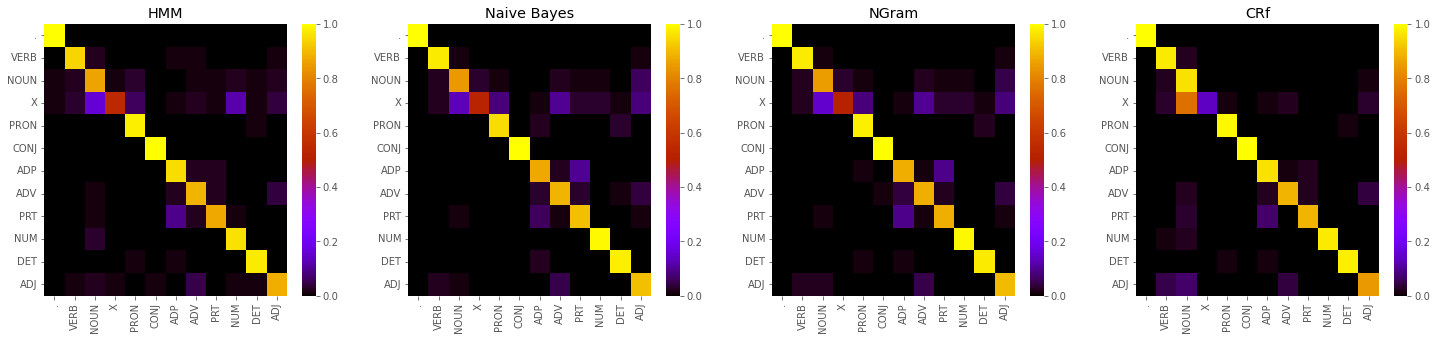

In [17]:
tags = set(tag for sent in dataset for (word, tag) in sent)
confusion_matrices = {}
for model_name, preds in predictions['test'].items():
    mat = confusion_matrix(test_tags, preds, labels = list(tags))
    confusion_matrices[model_name] =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), index=list(tags), columns=list(tags))


cmap = 'gnuplot'

fig, ax = plt.subplots(1,4, figsize = (25,5))
plt.style.use('ggplot')
for i, (model_name, mat) in enumerate(confusion_matrices.items()):
    
    sns.heatmap(mat, cmap = cmap, ax = ax[i])
    ax[i].set_title(model_name, c = 'black')



plt.show()

# Brill taggers

In [10]:
templates = nltk.tag.brill.fntbl37()

brill_tagger_trainer_hmm = BrillTaggerTrainer(hmm_tagger, templates,trace=3)
brill_tagger_hmm = brill_tagger_trainer_hmm.train(train_data,max_rules=10,min_score=100)

brill_tagger_trainer_nb = BrillTaggerTrainer(nb_tagger, templates,trace=3)
brill_tagger_nb = brill_tagger_trainer_nb.train(train_data,max_rules=10, min_score=100)

brill_tagger_trainer_ngram = BrillTaggerTrainer(ngram_tagger, templates,trace=3)
brill_tagger_ngram = brill_tagger_trainer_ngram.train(train_data,max_rules=10, min_score=100)

brill_tagger_trainer_crf = BrillTaggerTrainer(crf_tagger, templates, trace=3)
brill_tagger_crf = brill_tagger_trainer_crf.train(train_data,max_rules=10, min_score=100)



TBL train (fast) (seqs: 45872; tokens: 979646; tpls: 37; min score: 100; min acc: None)
Finding initial useful rules...
    Found 441566 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
 437 439   2   0  | ADP->ADV if Word:as@[0] & Word:as@[2]
 355 356   1   0  | ADJ->ADV if Word:most@[0] & Pos:ADJ@[1]
 248 251   3   0  | ADV->ADP if Word:as@[0] & Pos:ADP@[1]
 246 261  15   0  | ADV->ADP if Word:as@[0] & Pos:VERB@[1]
 237 241   4  17  | PRON->DET if Word:that@[0] & Pos:ADP@[-1]
 233 299  66   0  | ADV->ADJ if Word:more@[0] & Pos:ADP@[1]
 185 188   3   0  | ADV->ADP if Word:so@[0] & Word:that@[1]
 184 190   6   0  | ADJ->ADV if Word:more

In [11]:
brill_predictions = {}
brill_predictions_train = {}

brill_taggers = {'HMM' : brill_tagger_hmm, 'Naive Bayes': brill_tagger_nb,'NGram' : brill_tagger_ngram,'CRf' : brill_tagger_crf}

for model_name, tagger in brill_taggers.items():
    brill_predictions[model_name] = predict(test_data, tagger)
    brill_predictions_train[model_name] = predict(train_data, tagger)
        

In [13]:
brill_accuracy_scores_train = {}
brill_f1_scores_train = {}
brill_accuracy_scores_test = {}
brill_f1_scores_test = {}

for model_name, preds in brill_predictions_train.items():
    brill_accuracy_scores_train[model_name] = accuracy_score(train_tags ,preds).round(3)
    brill_f1_scores_train[model_name] = f1_score(train_tags ,preds, average='weighted').round(3)

for model_name, preds in brill_predictions.items():
    brill_accuracy_scores_test[model_name] = accuracy_score(test_tags ,preds).round(3)
    brill_f1_scores_test[model_name] = f1_score(test_tags,preds, average='weighted').round(3)
    
    

scores = pd.concat([pd.Series(brill_accuracy_scores_train), pd.Series(brill_accuracy_scores_test),
                    pd.Series(brill_f1_scores_train),pd.Series(brill_f1_scores_test)], axis=1)

headers = ['model (with brill)','train accuracy', 'test accuracy', 'train f1 score', 'test f1 score']

print(tabulate(scores, headers=headers, tablefmt='fancy_grid'))

╒══════════════════════╤══════════════════╤═════════════════╤══════════════════╤═════════════════╕
│ model (with brill)   │   train accuracy │   test accuracy │   train f1 score │   test f1 score │
╞══════════════════════╪══════════════════╪═════════════════╪══════════════════╪═════════════════╡
│ HMM                  │            0.973 │           0.939 │            0.973 │           0.94  │
├──────────────────────┼──────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ Naive Bayes          │            0.975 │           0.942 │            0.976 │           0.943 │
├──────────────────────┼──────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ NGram                │            0.98  │           0.939 │            0.98  │           0.942 │
├──────────────────────┼──────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ CRf                  │            0.97  │           0.96  │            0.97  │           0.96  │
╘═════════

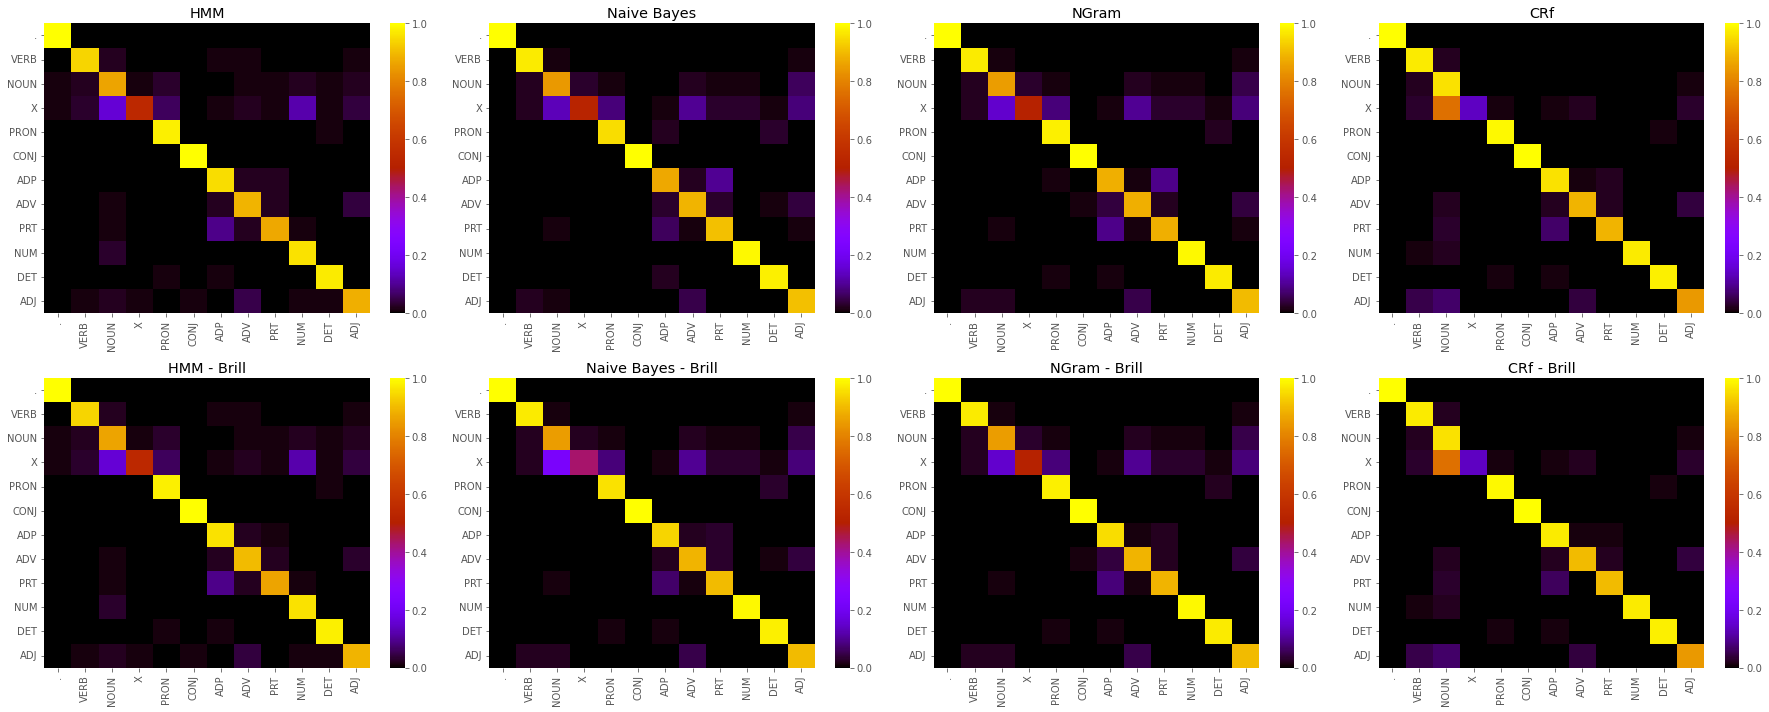

In [31]:
brill_confusion_matrices = {}
for model_name, preds in brill_predictions.items():
    mat = confusion_matrix(test_tags, preds, labels = list(tags))
    brill_confusion_matrices[model_name] =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), index=list(tags), columns=list(tags))


fig, ax = plt.subplots(2,4, figsize = (25,10))
plt.style.use('ggplot')


for i, (model_name, mat) in enumerate(confusion_matrices.items()):
    
    sns.heatmap(mat, cmap = cmap, ax = ax[0][i])
    ax[0][i].set_title(model_name, c = 'black')


for i, (model_name, mat) in enumerate(brill_confusion_matrices.items()):
    
    sns.heatmap(mat, cmap = cmap, ax = ax[1][i])
    ax[1][i].set_title(model_name + ' - Brill', c = 'black')
    

plt.tight_layout()
plt.show()

# Examples on sentences out the dataset

In [291]:
sentence = "As long as he seems as ran,i guess ran did it"
tagged_sentence_hmm = hmm_tagger.tag(nltk.word_tokenize(sentence))
tagged_sentence_brill = brill_tagger_hmm.tag(nltk.word_tokenize(sentence))
df = pd.DataFrame(tagged_sentence_hmm)
df[2] = pd.DataFrame(tagged_sentence_brill)[1]
print(tabulate(df,headers = ['word', 'HMM tag', 'HMM-Brill tag'], showindex=False,tablefmt = 'github'))

| word   | HMM tag   | HMM-Brill tag   |
|--------|-----------|-----------------|
| As     | ADP       | ADP             |
| long   | ADJ       | ADJ             |
| as     | ADP       | ADP             |
| he     | PRON      | PRON            |
| seems  | VERB      | VERB            |
| as     | ADV       | ADP             |
| ran    | VERB      | VERB            |
| ,      | .         | .               |
| i      | NOUN      | NOUN            |
| guess  | VERB      | VERB            |
| ran    | VERB      | VERB            |
| did    | VERB      | VERB            |
| it     | PRON      | PRON            |


In [290]:
sentence = "I didn't touch a thing that is yours"
tagged_sentence_nb = nb_tagger.tag(nltk.word_tokenize(sentence))
tagged_sentence_brill = brill_tagger_nb.tag(nltk.word_tokenize(sentence))

df = pd.merge(pd.DataFrame(tagged_sentence_nb), pd.DataFrame(tagged_sentence_brill),on = 0)
print(tabulate(df,headers = ['word', 'NB tag', 'NB-Brill tag'], showindex=False, tablefmt = 'github'))


| word   | NB tag   | NB-Brill tag   |
|--------|----------|----------------|
| I      | PRON     | PRON           |
| did    | VERB     | VERB           |
| n't    | VERB     | VERB           |
| touch  | VERB     | VERB           |
| a      | DET      | DET            |
| thing  | NOUN     | NOUN           |
| that   | ADP      | PRON           |
| is     | VERB     | VERB           |
| yours  | PRON     | PRON           |


In [289]:
sentence = "I was not talking to you"
tagged_sentence_ngram = ngram_tagger.tag(nltk.word_tokenize(sentence))
tagged_sentence_brill = brill_tagger_ngram.tag(nltk.word_tokenize(sentence))
df = pd.merge(pd.DataFrame(tagged_sentence_ngram), pd.DataFrame(tagged_sentence_brill),on = 0)
print(tabulate(df,headers = ['word', 'Ngram tag', 'Ngram-Brill tag'], showindex=False,tablefmt = 'github'))

| word    | Ngram tag   | Ngram-Brill tag   |
|---------|-------------|-------------------|
| I       | PRON        | PRON              |
| was     | VERB        | VERB              |
| not     | ADV         | ADV               |
| talking | VERB        | VERB              |
| to      | PRT         | ADP               |
| you     | PRON        | PRON              |


In [288]:
sentence = "He won the competition out of the blue"
tagged_sentence_crf = crf_tagger.tag(nltk.word_tokenize(sentence))
tagged_sentence_brill = brill_tagger_crf.tag(nltk.word_tokenize(sentence))
df = pd.DataFrame(tagged_sentence_crf)
df[2] = pd.DataFrame(tagged_sentence_brill)[1]
print(tabulate(df,headers = ['word', 'CRF tag', 'CRF-Brill tag'], showindex=False,tablefmt = 'github'))

| word        | CRF tag   | CRF-Brill tag   |
|-------------|-----------|-----------------|
| He          | PRON      | PRON            |
| won         | VERB      | VERB            |
| the         | DET       | DET             |
| competition | NOUN      | NOUN            |
| out         | PRT       | ADP             |
| of          | ADP       | ADP             |
| the         | DET       | DET             |
| blue        | ADJ       | ADJ             |
